<a href="https://colab.research.google.com/github/Philewj/CS-695-CNN-Implementation-MNIST/blob/main/CS_695_Project_CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Implementing CNN for the MNIST Dataset

## Building Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data

In [ ]:
#Covert MNIST Image Files into Tensors of 4 Dimensions (# of images, Height, Width, Color Channels)
transform = transforms.ToTensor()
#Load Training Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)
#Load Testing Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1MB/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [ ]:
#Verifying Training Data
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
#Verifying Testing Data
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Build Model

In [ ]:
#Model Class
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 Convolutional Layers
    self.convolution_layer1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3,stride=1)
    self.convolution_layer2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3,stride=1)

    #Fully Connected Neural Layers
    self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
    self.dropout1 = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=120, out_features=85) # decrease the number of out features (can be an arbitrary number)
    self.dropout2 = nn.Dropout(0.25)
    self.fc3 = nn.Linear(in_features=85, out_features=55) # is the number of classes in the dataset
    self.dropout3 = nn.Dropout(0.25)
    self.fc4 = nn.Linear(in_features=55, out_features=10) # is the number of classes in the dataset

  def forward(self, X):
    # Pass through Convolutional Layer 1
    X = F.relu(self.convolution_layer1(X))
    X = F.max_pool2d(X, 2, 2)
    # Pass through Convolutional Layer 2
    X = F.relu(self.convolution_layer2(X))
    X = F.max_pool2d(X, 2, 2)

    #Re-View data to flatten it out
    X = X.view(-1, 16*5*5) # -1 so we can vary batch size

    #Pass through the Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = self.dropout1(X)
    X = F.relu(self.fc2(X))
    X = self.dropout2(X)
    X = F.relu(self.fc3(X))
    X = self.dropout3(X)
    X = self.fc4(X)
    return F.log_softmax(X, dim=1)

In [ ]:
#Create an Intance of the Model
#Create a manual seed
torch.manual_seed(34)
model = ConvolutionalNeuralNetwork()
model

ConvolutionalNeuralNetwork(
  (convolution_layer1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (convolution_layer2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=120, out_features=85, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=85, out_features=55, bias=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc4): Linear(in_features=55, out_features=10, bias=True)
)

In [ ]:
#Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training and Validation Accuracy/Loss

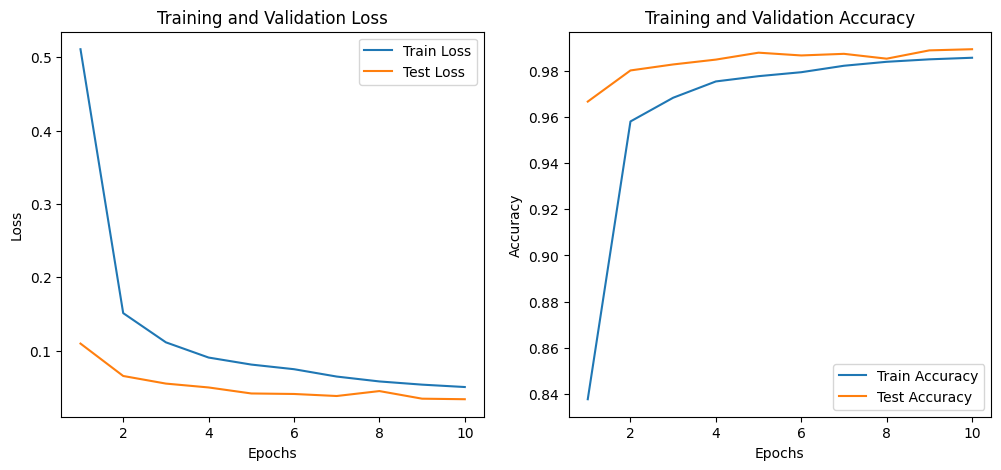

In [ ]:

# Function to train and log accuracy/loss
def train_and_log(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / len(train_loader.dataset))

        # Evaluate on the test set
        model.eval()
        test_loss = 0.0
        correct = 0
        with torch.no_grad():
            for X_test, y_test in test_loader:
                outputs = model(X_test)
                loss = criterion(outputs, y_test)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_test).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / len(test_loader.dataset))

    return train_losses, test_losses, train_accuracies, test_accuracies

# Plotting function
def plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, test_accuracies, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.show()

# Example usage
model = ConvolutionalNeuralNetwork()#(dropout=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

train_losses, test_losses, train_accuracies, test_accuracies = train_and_log(
    model, train_loader, test_loader, optimizer, criterion, epochs=10
)

# Plot the curves
plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies)


### Visualizing Filters and Feature Maps

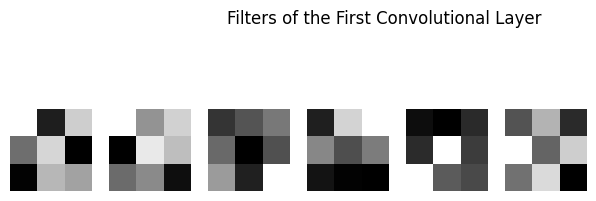

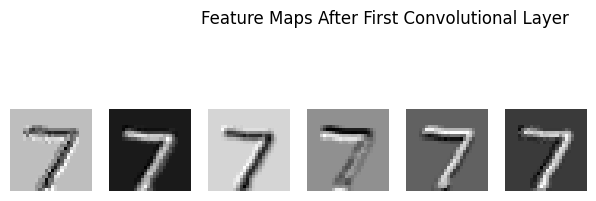

In [ ]:

# Visualizing filters of the first convolutional layer
def visualize_filters(model):
    # Access the weights of the first convolutional layer
    conv1_weights = model.convolution_layer1.weight.data.cpu()
    num_filters = conv1_weights.shape[0]  # Number of filters

    plt.figure(figsize=(10, 10))
    for i in range(num_filters):
        plt.subplot(8, 8, i + 1)  # Adjust grid size based on the number of filters
        plt.imshow(conv1_weights[i, 0, :, :], cmap="gray")
        plt.axis("off")
    plt.suptitle("Filters of the First Convolutional Layer")
    plt.show()

# Visualizing feature maps for an input image
def visualize_feature_maps(model, image):
    with torch.no_grad():
        # Pass the image through the first convolutional layer
        conv1_output = model.convolution_layer1(image.unsqueeze(0))

    # Convert feature maps to numpy for visualization
    feature_maps = conv1_output.squeeze(0).cpu().numpy()

    plt.figure(figsize=(10, 10))
    for i in range(feature_maps.shape[0]):
        plt.subplot(8, 8, i + 1)  # Adjust grid size
        plt.imshow(feature_maps[i, :, :], cmap="gray")
        plt.axis("off")
    plt.suptitle("Feature Maps After First Convolutional Layer")
    plt.show()

# Visualize filters and feature maps
visualize_filters(model)
image = test_data[0][0]  # Use the first test image
visualize_feature_maps(model, image)


### Hyperparameter Analysis

In [ ]:

import time
# Function to train the model with different hyperparameters
def train_with_hyperparameters(learning_rates, dropout_rates, batch_sizes):
    results = []  # To store results for each configuration

    for lr in learning_rates:
        for dropout in dropout_rates:
            for batch_size in batch_sizes:
                print(f"Training with LR={lr}, Dropout={dropout}, Batch Size={batch_size}")

                # Define the model with the given dropout
                #model = ConvolutionalNeuralNetwork(dropout=dropout)
                model = ConvolutionalNeuralNetwork()
                model.dropout1 = nn.Dropout(dropout)
                model.dropout2 = nn.Dropout(dropout)
                model.dropout3 = nn.Dropout(dropout)
                criterion = nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # DataLoader with the given batch size
                train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

                # Training loop
                start_time = time.time()
                model.train()
                for epoch in range(5):  # Train for 5 epochs
                    running_loss = 0.0
                    for X_batch, y_batch in train_loader:
                        optimizer.zero_grad()
                        outputs = model(X_batch)
                        loss = criterion(outputs, y_batch)
                        loss.backward()
                        optimizer.step()
                        running_loss += loss.item()

                # Evaluate on test set
                model.eval()
                correct = 0
                with torch.no_grad():
                    for X_test, y_test in test_loader:
                        outputs = model(X_test)
                        _, predicted = torch.max(outputs, 1)
                        correct += (predicted == y_test).sum().item()

                accuracy = correct / len(test_data)
                training_time = time.time() - start_time

                # Save results
                results.append({
                    "Learning Rate": lr,
                    "Dropout": dropout,
                    "Batch Size": batch_size,
                    "Accuracy": accuracy,
                    "Training Time (s)": training_time
                })
                print(f"Accuracy: {accuracy:.4f}, Time: {training_time:.2f}s")

    return results

# Example hyperparameters
learning_rates = [0.001, 0.01]
dropout_rates = [0.2, 0.5]
batch_sizes = [64, 128]

# Run the experiments
results = train_with_hyperparameters(learning_rates, dropout_rates, batch_sizes)

# Visualize the results
results_df = pd.DataFrame(results)
print(results_df)


Training with LR=0.001, Dropout=0.2, Batch Size=64
Accuracy: 0.9891, Time: 72.23s
Training with LR=0.001, Dropout=0.2, Batch Size=128
Accuracy: 0.9847, Time: 65.81s
Training with LR=0.001, Dropout=0.5, Batch Size=64
Accuracy: 0.9815, Time: 74.15s
Training with LR=0.001, Dropout=0.5, Batch Size=128
Accuracy: 0.9754, Time: 64.75s
Training with LR=0.01, Dropout=0.2, Batch Size=64
Accuracy: 0.9766, Time: 72.78s
Training with LR=0.01, Dropout=0.2, Batch Size=128
Accuracy: 0.9828, Time: 65.54s
Training with LR=0.01, Dropout=0.5, Batch Size=64
Accuracy: 0.9732, Time: 70.88s
Training with LR=0.01, Dropout=0.5, Batch Size=128
Accuracy: 0.9755, Time: 65.93s
   Learning Rate  Dropout  Batch Size  Accuracy  Training Time (s)
0          0.001      0.2          64    0.9891          72.229340
1          0.001      0.2         128    0.9847          65.812704
2          0.001      0.5          64    0.9815          74.153069
3          0.001      0.5         128    0.9754          64.753971
4        